# Matching pipeline

The comparison method is used in statistical analysis to eliminate distortions caused by differences in the basic characteristics of the studied groups. Simply put, matching helps to make sure that the results of the experiment are really caused by the studied effect, and not by external factors.

Matching is most often performed in cases where the use of a standard AB test is impossible.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from hypex import Matching
from hypex.dataset import (
    Dataset,
    FeatureRole,
    GroupingRole,
    InfoRole,
    TargetRole,
    TreatmentRole,
)
from hypex.utils import create_test_data

# Create synthetic data

In [2]:
df = create_test_data().bfill()
df["post_spends"] = df["pre_spends"] + np.random.rand(len(df))
df[["signup_month", "treat"]] = df[["signup_month", "treat"]].astype(int)
df

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry
0,0.0,0,0,475.0,475.696965,23.0,M,E-commerce
1,1.0,11,1,487.0,487.535208,51.0,F,Logistics
2,2.0,0,0,484.0,484.320639,35.0,M,E-commerce
3,3.0,11,1,494.5,495.159047,29.0,M,Logistics
4,4.0,0,0,455.5,455.675909,53.0,M,E-commerce
...,...,...,...,...,...,...,...,...
9995,9995.0,5,1,487.5,487.741243,31.0,M,Logistics
9996,9996.0,11,1,453.5,454.099548,41.0,M,E-commerce
9997,9997.0,10,1,482.0,482.308959,58.0,F,Logistics
9998,9998.0,6,1,477.0,477.867590,41.0,F,E-commerce


Basic statistics for numerical features:


,user_id,signup_month,treat,pre_spends,post_spends,age
count,10000.0,10000.00,10000.0,10000.00,10000.00,10000.00
mean,4999.6,3.01,0.5,487.05,487.55,43.60
std,2886.9,3.75,0.5,18.77,18.77,14.89
min,0.0,0.00,0.0,427.00,427.47,18.00
25%,2500.5,0.00,0.0,474.50,475.15,31.00
50%,5000.0,1.00,1.0,485.50,486.15,44.00
75%,7499.5,6.00,1.0,497.00,497.30,56.00
max,9999.0,11.00,1.0,581.50,582.28,69.00


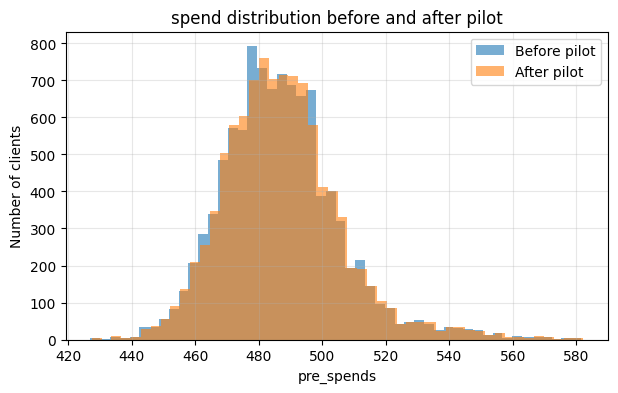

In [3]:
def describe_basic_info(df: pd.DataFrame):
    print("Basic statistics for numerical features:")
    display(df.describe().round(2))

def describe_cltv_effect(df: pd.DataFrame, group_col="treat"):
    result = (
        df.groupby(group_col)[["pre_spends", "post_spends"]]
        .mean()
        .rename(columns={"pre_spends": "mean_pre_spends", "post_spends": "mean_post_spends"})
    )
    result["delta_spend"] = result["post_spends"] - result["pre_spends"]
    print("Average spend before and after pilot:")
    print(result.round(2))
    result.plot(
        kind="bar",
        figsize=(6, 4),
        title="Average spend before and after pilot by groups",
        rot=0
    )
    plt.ylabel("Average spend")
    plt.grid(alpha=0.3)
    plt.show()

    return result

def plot_cltv_distribution(df: pd.DataFrame):
    plt.figure(figsize=(7, 4))
    plt.hist(df["pre_spends"], bins=50, alpha=0.6, label="Before pilot")
    plt.hist(df["post_spends"], bins=50, alpha=0.6, label="After pilot")
    plt.title("spend distribution before and after pilot")
    plt.xlabel("pre_spends")
    plt.ylabel("Number of clients")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


def full_dataset_report(df: pd.DataFrame):
    describe_basic_info(df)
    plot_cltv_distribution(df)

full_dataset_report(df)

# Define the Dataset

In [4]:
data = Dataset(
    roles={
        "user_id": InfoRole(int),
        "treat": TreatmentRole(int),
        "post_spends": TargetRole(float),
        "gender": FeatureRole(str),
        "pre_spends": FeatureRole(float),
        "industry": FeatureRole(str),
        "age": FeatureRole(int),
    },
    data=df,
    default_role=InfoRole(),
)
data

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry
0,0,0,0,475.0,475.696965,23,M,E-commerce
1,1,11,1,487.0,487.535208,51,F,Logistics
2,2,0,0,484.0,484.320639,35,M,E-commerce
3,3,11,1,494.5,495.159047,29,M,Logistics
4,4,0,0,455.5,455.675909,53,M,E-commerce
...,...,...,...,...,...,...,...,...
9995,9995,5,1,487.5,487.741243,31,M,Logistics
9996,9996,11,1,453.5,454.099548,41,M,E-commerce
9997,9997,10,1,482.0,482.308959,58,F,Logistics
9998,9998,6,1,477.0,477.867590,41,F,E-commerce


In [5]:
data.roles

{'user_id': Info(<class 'int'>),
 'treat': Treatment(<class 'int'>),
 'post_spends': Target(<class 'float'>),
 'gender': Feature(data_type=<class 'str'>),
 'pre_spends': Feature(data_type=<class 'float'>),
 'industry': Feature(data_type=<class 'str'>),
 'age': Feature(data_type=<class 'int'>),
 'signup_month': Info(<class 'int'>)}

# Basic Matching without parameters

Main matching steps (in HypEx):

1. **Dummy Encoder**
   Converts categorical features to numerical format 

2. **Distance matrix calculation (usually Mahalanobis)**
   
3. **Finding nearest pairs (via FAISS)**
   
4. **Quality check of twin matching**

5. **Effect estimation (ATT, ATC, ATE)**

In [6]:
data = data.fillna(method="bfill")
test = Matching()
result = test.execute(data)

In [7]:
result.resume

,Effect Size,Standard Error,P-value,CI Lower,CI Upper,outcome
ATT,0.00,0.01,0.89,-0.02,0.03,post_spends
ATC,0.01,0.01,0.37,-0.01,0.03,post_spends
ATE,0.01,0.01,0.56,-0.01,0.03,post_spends


### ATT — Average Treatment effect on the Treated

$
ATT = E[Y(1) - Y(0) \mid T=1]
$
 - shows **how the treatment affected those who actually received it**.

### ATC — Average Treatment effect on the Controls 

$
ATC = E[Y(1) - Y(0) \mid T=0]
$
 - shows **what would have happened to the control group if they had received the treatment**.

### ATE — Average Treatment Effect

$
ATE = E[Y(1) - Y(0)]
$
- the overall average effect in the population — a combination of ATT and ATC, weighted by group sizes.

In [8]:
result.indexes

,indexes_0
0,2744
1,5529
2,5628
3,582
4,2247
...,...
9995,386
9996,4685
9997,3842
9998,5548


In [9]:
result.full_data

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry,user_id_matched_0,signup_month_matched_0,treat_matched_0,pre_spends_matched_0,post_spends_matched_0,age_matched_0,gender_matched_0,industry_matched_0
0,0,0,0,475.0,475.696965,23.0,M,E-commerce,2744,11,1,475.0,475.896827,23.0,M,E-commerce
1,1,11,1,487.0,487.535208,51.0,F,Logistics,5529,0,0,486.5,487.441640,51.0,F,Logistics
2,2,0,0,484.0,484.320639,35.0,M,E-commerce,5628,5,1,484.5,485.391149,34.0,M,E-commerce
3,3,11,1,494.5,495.159047,29.0,M,Logistics,582,0,0,494.5,494.877988,29.0,M,Logistics
4,4,0,0,455.5,455.675909,53.0,M,E-commerce,2247,11,1,455.5,455.833920,54.0,M,E-commerce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,5,1,487.5,487.741243,31.0,M,Logistics,386,0,0,487.0,487.204044,31.0,M,Logistics
9996,9996,11,1,453.5,454.099548,41.0,M,E-commerce,4685,0,0,454.0,454.738503,45.0,M,E-commerce
9997,9997,10,1,482.0,482.308959,58.0,F,Logistics,3842,0,0,481.5,481.902546,57.0,F,Logistics
9998,9998,6,1,477.0,477.867590,41.0,F,E-commerce,5548,0,0,478.5,479.044356,41.0,F,E-commerce


## Distances: `distance="mahalanobis"` or `"l2"`

### 🔸 Euclidean (L2)

This is the classic metric:
$ d(x_i, x_j) = \sqrt{\sum_k (x_{ik} - x_{jk})^2} $
Simply measures the "geometric" distance between points in feature space.

### 🔸 Mahalanobis distance

A more advanced metric:
$ d_M(x_i, x_j) = \sqrt{(x_i - x_j)^T \Sigma^{-1} (x_i - x_j)} $
where $\Sigma$ is the covariance matrix of features.
This metric accounts for the scale and correlation of features, making the comparison more accurate:

In [10]:
test = Matching(distance='l2')
result = test.execute(data)

In [11]:
result.resume

,Effect Size,Standard Error,P-value,CI Lower,CI Upper,outcome
ATT,0.01,0.01,0.60,-0.02,0.03,post_spends
ATC,0.00,0.01,0.75,-0.02,0.03,post_spends
ATE,0.01,0.01,0.61,-0.02,0.03,post_spends


In [12]:
test = Matching(distance='mahalanobis')
result = test.execute(data)

In [13]:
result.resume

,Effect Size,Standard Error,P-value,CI Lower,CI Upper,outcome
ATT,0.00,0.01,0.89,-0.02,0.03,post_spends
ATC,0.01,0.01,0.37,-0.01,0.03,post_spends
ATE,0.01,0.01,0.56,-0.01,0.03,post_spends


# `group_match`: matching by groups

The parameter `group_match=True` forces HypEx to aggregate observations into groups (by a specified identifier), and then search for pairs between groups rather than individual objects.
This reduces variability at the individual level and allows for effect estimation at more aggregated levels.

In [14]:
data = Dataset(
    roles={
        "user_id": InfoRole(int),
        "treat": TreatmentRole(int),
        "post_spends": TargetRole(float),
        "gender": GroupingRole(str),
        "pre_spends": FeatureRole(float),
        "industry": FeatureRole(str),
        "age": FeatureRole(int),
    },
    data=df,
    default_role=InfoRole(),
)
data['gender'].unique()

{'gender': array(['M', 'F'], dtype=object)}

We can change **metric** and do estimation again.

In [15]:
test = Matching(group_match=True)
result = test.execute(data)

100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


In [16]:
result.resume

,F Effect Size,M Effect Size,F Standard Error,M Standard Error,F P-value,M P-value,F CI Lower,M CI Lower,F CI Upper,M CI Upper,outcome
ATT,0.00,0.0,0.02,0.02,0.80,0.99,-0.03,-0.03,0.04,0.03,post_spends
ATC,0.02,-0.0,0.02,0.02,0.31,0.81,-0.01,-0.04,0.05,0.03,post_spends
ATE,0.01,-0.0,0.01,0.01,0.47,0.90,-0.02,-0.03,0.04,0.03,post_spends


# `bias_estimation`: bias estimation and correction

When `bias_estimation=True`, HypEx:

1. **Estimates residual imbalance** across all features after matching (e.g., using standardized mean difference, t-tests, etc.);
2. **Corrects the final effect estimate** to reduce the impact of remaining bias.


In [17]:
data = Dataset(
    roles={
        "user_id": InfoRole(int),
        "treat": TreatmentRole(int),
        "post_spends": TargetRole(float),
        "gender": FeatureRole(str),
        "pre_spends": FeatureRole(float),
        "industry": FeatureRole(str),
        "age": FeatureRole(int),
    },
    data=df,
    default_role=InfoRole(),
)

In [18]:
test = Matching(bias_estimation=False)
result = test.execute(data)

In [19]:
result.resume

,Effect Size,Standard Error,P-value,CI Lower,CI Upper,outcome
ATT,0.65,0.06,0.00,0.53,0.76,post_spends
ATC,0.06,0.09,0.52,-0.12,0.23,post_spends
ATE,0.35,0.07,0.00,0.22,0.48,post_spends


# `quality_tests`: matching quality checks

Main tests:

* `'ks-test'` — Kolmogorov–Smirnov test for comparing distributions;
* `'t-test'` — test for equality of means;
* `'chi2-test'` — test for independence of categorical features;

These tests help understand whether balance was achieved and how reliable the result can be considered.

In [20]:
test = Matching(quality_tests=['chi2-test', 'ks-test', 't-test'])
result = test.execute(data)

In [21]:
result.resume

,Effect Size,Standard Error,P-value,CI Lower,CI Upper,outcome
ATT,0.00,0.01,0.89,-0.02,0.03,post_spends
ATC,0.01,0.01,0.37,-0.01,0.03,post_spends
ATE,0.01,0.01,0.56,-0.01,0.03,post_spends


In [22]:
result.quality_results

,feature,group,TTest pass,TTest p-value,KSTest pass,KSTest p-value,Chi2Test pass,Chi2Test p-value
0,pre_spends,0┆pre_spends,OK,0.879358,OK,0.999905,NaN,NaN
1,pre_spends,1┆pre_spends,OK,0.109933,OK,0.093432,NaN,NaN
2,age,0┆age,OK,0.946168,OK,1.000000,NaN,NaN
3,age,1┆age,OK,0.869023,OK,0.975792,NaN,NaN
4,gender,0┆gender,NaN,NaN,NaN,NaN,OK,1.0
5,gender,1┆gender,NaN,NaN,NaN,NaN,OK,1.0
6,industry,0┆industry,NaN,NaN,NaN,NaN,OK,1.0
7,industry,1┆industry,NaN,NaN,NaN,NaN,OK,1.0


# `faiss_mode`: search acceleration

FAISS is a high-performance library for nearest neighbor search, developed by Meta AI.
HypEx uses it for finding pairs in large datasets.

Modes:

* `'base'` — exact but slow search;
* `'fast'` — approximate but fast (uses indexing);
* `'auto'` — HypEx automatically chooses the optimal option depending on data size.


In [23]:
test = Matching(faiss_mode="base")
result = test.execute(data)
result.resume

,Effect Size,Standard Error,P-value,CI Lower,CI Upper,outcome
ATT,0.00,0.01,0.89,-0.02,0.03,post_spends
ATC,0.01,0.01,0.37,-0.01,0.03,post_spends
ATE,0.01,0.01,0.56,-0.01,0.03,post_spends


Finally, we may search pairs in L2 distance. 

In [24]:
test = Matching(faiss_mode="fast")
result = test.execute(data)
result.resume

WARNING clustering 4981 points to 1000 centroids: please provide at least 39000 training points
WARNING clustering 5019 points to 1000 centroids: please provide at least 39000 training points


,Effect Size,Standard Error,P-value,CI Lower,CI Upper,outcome
ATT,0.00,0.01,0.93,-0.02,0.03,post_spends
ATC,0.01,0.01,0.41,-0.01,0.03,post_spends
ATE,0.01,0.01,0.61,-0.01,0.03,post_spends


# `n_neighbors`: number of neighbors

Determines how many control objects will be matched for each object from the treatment group.

* `n_neighbors=1` — classic **one-to-one matching**;
* `n_neighbors>1` — **one-to-many matching**, when one treated object corresponds to multiple control objects.


In [25]:
test = Matching(n_neighbors=3)
result = test.execute(data)
result.resume

/home/tony_montana/job/HypEx/hypex/comparators/abstract.py:196: UserWarning: baseline_field_data must have only one column when the comparison is done by matched_pairs. 3 passed. FaissNearestNeighbors┴┴┴0 will be used.
  warnings.warn(
/home/tony_montana/job/HypEx/hypex/comparators/abstract.py:196: UserWarning: baseline_field_data must have only one column when the comparison is done by matched_pairs. 3 passed. FaissNearestNeighbors┴┴┴0 will be used.
  warnings.warn(
/home/tony_montana/job/HypEx/hypex/comparators/abstract.py:196: UserWarning: baseline_field_data must have only one column when the comparison is done by matched_pairs. 3 passed. FaissNearestNeighbors┴┴┴0 will be used.
  warnings.warn(
/home/tony_montana/job/HypEx/hypex/comparators/abstract.py:196: UserWarning: baseline_field_data must have only one column when the comparison is done by matched_pairs. 3 passed. FaissNearestNeighbors┴┴┴0 will be used.
  warnings.warn(
/home/tony_montana/job/HypEx/hypex/comparators/abstract.

,Effect Size,Standard Error,P-value,CI Lower,CI Upper,outcome
ATT,-0.0,0.01,0.64,-0.02,0.01,post_spends
ATC,0.0,0.01,0.85,-0.01,0.02,post_spends
ATE,-0.0,0.01,0.87,-0.02,0.01,post_spends


In [26]:
result.indexes

,indexes_0,indexes_1,indexes_2
0,2744,2487,3192
1,5529,2706,8209
2,5628,6447,6387
3,582,6814,2530
4,2247,6796,3579
...,...,...,...
9995,386,4266,1673
9996,4685,4805,7295
9997,3842,286,5800
9998,5548,1259,3453


In [27]:
result.full_data

,user_id,signup_month,treat,pre_spends,post_spends,age,gender,industry,user_id_matched_0,signup_month_matched_0,...,gender_matched_1,industry_matched_1,user_id_matched_2,signup_month_matched_2,treat_matched_2,pre_spends_matched_2,post_spends_matched_2,age_matched_2,gender_matched_2,industry_matched_2
0,0,0,0,475.0,475.696965,23.0,M,E-commerce,2744,11,...,M,E-commerce,2744,11,1,475.0,475.896827,23.0,M,E-commerce
1,1,11,1,487.0,487.535208,51.0,F,Logistics,5529,0,...,F,Logistics,5529,0,0,486.5,487.441640,51.0,F,Logistics
2,2,0,0,484.0,484.320639,35.0,M,E-commerce,5628,5,...,M,E-commerce,5628,5,1,484.5,485.391149,34.0,M,E-commerce
3,3,11,1,494.5,495.159047,29.0,M,Logistics,582,0,...,M,Logistics,582,0,0,494.5,494.877988,29.0,M,Logistics
4,4,0,0,455.5,455.675909,53.0,M,E-commerce,2247,11,...,M,E-commerce,2247,11,1,455.5,455.833920,54.0,M,E-commerce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,5,1,487.5,487.741243,31.0,M,Logistics,386,0,...,M,Logistics,386,0,0,487.0,487.204044,31.0,M,Logistics
9996,9996,11,1,453.5,454.099548,41.0,M,E-commerce,4685,0,...,M,E-commerce,4685,0,0,454.0,454.738503,45.0,M,E-commerce
9997,9997,10,1,482.0,482.308959,58.0,F,Logistics,3842,0,...,F,Logistics,3842,0,0,481.5,481.902546,57.0,F,Logistics
9998,9998,6,1,477.0,477.867590,41.0,F,E-commerce,5548,0,...,F,E-commerce,5548,0,0,478.5,479.044356,41.0,F,E-commerce


# `weights`: feature weights

Not all features may be equally important for matching pairs.
The `weights` parameter allows you to explicitly set priorities for features.


In [28]:
test = Matching(weights={"gender": 0.2, "industry": 0.3, "age": 0.1, "signup_month": 0.1, "pre_spends": 0.3})
result = test.execute(data)
result.resume

,Effect Size,Standard Error,P-value,CI Lower,CI Upper,outcome
ATT,0.00,0.01,0.96,-0.02,0.03,post_spends
ATC,0.01,0.01,0.50,-0.01,0.03,post_spends
ATE,0.00,0.01,0.69,-0.02,0.02,post_spends


# `encode_categories`: encoding categorical features

If `encode_categories=True` (default), HypEx automatically converts categorical features to numerical form (one-hot encoding).
If False — the library expects that the user has already encoded them.
This step is necessary so that all features can participate in distance calculations.


In [29]:
test = Matching(encode_categories=False)
result = test.execute(data)
result.resume

,Effect Size,Standard Error,P-value,CI Lower,CI Upper,outcome
ATT,-0.00,0.01,0.98,-0.03,0.03,post_spends
ATC,0.01,0.01,0.48,-0.02,0.03,post_spends
ATE,0.00,0.01,0.71,-0.02,0.03,post_spends
